In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import webdataset as wds
import wids

# OCR Evaluation

This is a small repository containing code for measuring error rates of OCR systems.

OCR output and ground truth are assumed to be in hOCR format, Markdown, or plain text format.

Collections of pages and text files are assumed to be in WebDataset format (meaning, .tar archives with related files grouped together by name.)

Two evaluations are possible:

- text based evaluation performs a rough estimate of a block move edit distance
- bounding box based evaluation puts OCR and ground truth into correspondence using geometric information

Both evaluation methods use heuristics to arrive at error estimates. Nevertheless, they should be good enough to assess the relative performance of different OCR engines.

# Installation

There is a small `Makefile`:

- `make venv` -- install/update the virtual environment
- `make README.md` -- update the README from the notebook
- `make install` -- install in $HOME or globally

# Evaluation Dataset

We start with a small evaluation dataset of 100 pages stored in a tar archive (with WebDataset conventions).

In [2]:
!mkdir -p testdata
!test -f testdata/ocr-eval-hocr.tar || curl -L https://storage.googleapis.com/ocropus4-data/eval/eval100.tar > testdata/ocr-eval-hocr.tar
!tar tvf testdata/ocr-eval-hocr.tar | head

drwxrwxr-x tmb/tmb           0 2023-12-24 04:46 ./
-r--r--r-- tmb/tmb        4479 2023-12-22 10:39 ./A00G.hocr.html
-rw-rw-r-- tmb/tmb     1125064 2023-12-24 04:45 ./A00G.page.jpg
-r--r--r-- tmb/tmb       17329 2023-12-22 10:39 ./A00O.hocr.html
-rw-rw-r-- tmb/tmb     2239762 2023-12-24 04:45 ./A00O.page.jpg
-r--r--r-- tmb/tmb        8939 2023-12-22 10:39 ./A04A.hocr.html
-rw-rw-r-- tmb/tmb     1022430 2023-12-24 04:46 ./A04A.page.jpg
-r--r--r-- tmb/tmb       10370 2023-12-22 10:39 ./A053.hocr.html
-rw-rw-r-- tmb/tmb     1777534 2023-12-24 04:46 ./A053.page.jpg
-r--r--r-- tmb/tmb        8813 2023-12-22 10:39 ./A06C.hocr.html
tar: stdout: write error


Looking at the images, we notice that there are page frames and (on some page) even text from opposing sides. This hinders OCR error evaluation.

[{'url': 'testdata/ocr-eval-hocr.tar', 'nsamples': base: None name: None nfiles: 1 nbytes: 0 samples: 100 cache: /tmp/_wids_cache


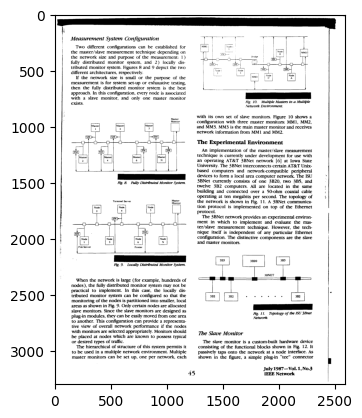

In [3]:
raw = wids.ShardListDataset([dict(url="testdata/ocr-eval-hocr.tar", nsamples=100)])
plt.imshow(raw[66][".page.jpg"], cmap="gray")

To remove the page frame, we run the `runocr reframe` command. This command infers a text bounding box from the hOCR ground truth and masks out any content outside that bounding box.

In [4]:
!runocr reframe testdata/ocr-eval-hocr.tar --output ocr-eval-hocr-reframed.tar --hocr hocr.html --img page.jpg

0 ./A00G 779 242 2314 2537
25 ./H00R 575 660 2084 3124
58 ./W089 287 182 2039 3032


[{'url': 'ocr-eval-hocr-reframed.tar', 'nsamples': base: None name: None nfiles: 1 nbytes: 0 samples: 100 cache: /tmp/_wids_cache


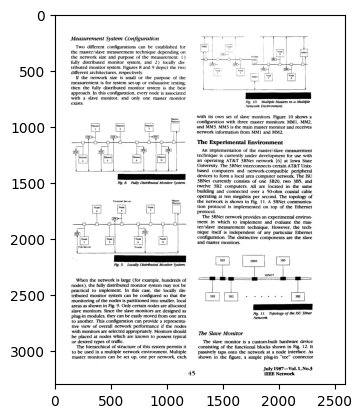

In [5]:
reframed = wids.ShardListDataset([dict(url="ocr-eval-hocr-reframed.tar", nsamples=100)])
plt.imshow(reframed[66][".page.jpg"], cmap="gray")

# Running OCR

The `runocr runocr` command runs the Tesseract OCR engine over the page images in the input shard.

In [6]:
!runocr runocr ocr-eval-hocr-reframed.tar --output ocr-eval-hocr-reframed-ocr.tar 

0 ./A00G 537; x_wconf 54\'>Delfzijl</span>\n     </span>\n    </p>\n   </div>\n  </div>\n </body>\n</html>\n'
2 ./A04A 464; x_wconf 90\'>287-302.</span>\n     </span>\n    </p>\n   </div>\n  </div>\n </body>\n</html>\n'
6 ./C00J 2401 3203; x_wconf 93\'>41</span>\n     </span>\n    </p>\n   </div>\n  </div>\n </body>\n</html>\n'
10 ./D03I 3044; x_wconf 96\'>plates.</span>\n     </span>\n    </p>\n   </div>\n  </div>\n </body>\n</html>\n'
15 ./E019 288 2990; x_wconf 90\'>(b)</span>\n     </span>\n    </p>\n   </div>\n  </div>\n </body>\n</html>\n'
21 ./E04D 2447 3160; x_wconf 85\'>).</span>\n     </span>\n    </p>\n   </div>\n  </div>\n </body>\n</html>\n'
31 ./J00I 954; x_wconf 95\'>surface.</span>\n     </span>\n    </p>\n   </div>\n  </div>\n </body>\n</html>\n'
43 ./S00G 2759; x_wconf 64\'>J61-64.</span>\n     </span>\n    </p>\n   </div>\n  </div>\n </body>\n</html>\n'
55 ./W078 84 2852; x_wconf 96\'>1993</span>\n     </span>\n    </p>\n   </div>\n  </div>\n </body>\n</html>\n'
71 .

In [7]:
!tar tvf ocr-eval-hocr-reframed-ocr.tar | head

-r--r--r-- bigdata/bigdata 4479 2023-12-24 04:53 ./A00G.hocr.html
-r--r--r-- bigdata/bigdata 1182137 2023-12-24 04:53 ./A00G.page.jpg
-r--r--r-- bigdata/bigdata   22459 2023-12-24 04:53 ./A00G.tess.html
-r--r--r-- bigdata/bigdata   17329 2023-12-24 04:53 ./A00O.hocr.html
-r--r--r-- bigdata/bigdata 4136054 2023-12-24 04:53 ./A00O.page.jpg
-r--r--r-- bigdata/bigdata  125879 2023-12-24 04:53 ./A00O.tess.html
-r--r--r-- bigdata/bigdata    8939 2023-12-24 04:53 ./A04A.hocr.html
-r--r--r-- bigdata/bigdata 1601983 2023-12-24 04:53 ./A04A.page.jpg
-r--r--r-- bigdata/bigdata   45653 2023-12-24 04:53 ./A04A.tess.html
-r--r--r-- bigdata/bigdata   10370 2023-12-24 04:53 ./A053.hocr.html
tar: stdout: write error


# OCR Error Evaluation using Text

To evaluate OCR results, we need to compare the ground truth text against the output of the OCR engine.

There are three ways of doing this:

1. If the OCR results and ground truth are contained in the same shard, you can just run `ocrtexteval evalocr` on the shard(s)
2. If the OCR results and ground truth are contained in different shards but are in the same order, you can zip them together using the `--gtshard` argument to `evalocr`.
3. If the OCR results are in a different order from the ground truth, you can load the ground truth into a database with `loadgt` and then use `--gtdb` for evaluation.

Here, we kept ground truth and OCR results together in the same shard, so we can use (1).

Output from `evalocr` is always in the form of an sqlite3 database.

In [8]:
!tar tvf ocr-eval-hocr-reframed-ocr.tar | sed 5q

-r--r--r-- bigdata/bigdata 4479 2023-12-24 04:53 ./A00G.hocr.html
-r--r--r-- bigdata/bigdata 1182137 2023-12-24 04:53 ./A00G.page.jpg
-r--r--r-- bigdata/bigdata   22459 2023-12-24 04:53 ./A00G.tess.html
-r--r--r-- bigdata/bigdata   17329 2023-12-24 04:53 ./A00O.hocr.html
-r--r--r-- bigdata/bigdata 4136054 2023-12-24 04:53 ./A00O.page.jpg
tar: stdout: write error


In [9]:
!rm -f ocr_eval.db
!ocrtexteval texteval ocr-eval-hocr-reframed-ocr.tar --gtkey hocr.html --ocrkey tess.html --output ocr_eval.db

0 ./A00G 0.02488839285714286 0.02683333333333333 1
3 ./A053 0.018118292987272272 0.019651741293532338 2
12 ./D05N 0.025121951219512197 0.03773529411764706 2
21 ./E04D 0.024269005847953218 0.01138586956521739 8
42 ./N05I 0.002699100299900034 0.005165562913907285 0
53 ./W038 0.007737941707505804 0.01266581632653061 0
68 ./W0IK 0.018017127799736497 0.02528846153846154 0
92 ./W1J6 0.005410225921521999 0.008549528301886792 0


In [10]:
import pandas as pd
import sqlite3

db = sqlite3.connect('ocr_eval.db')
df = pd.read_sql_query("SELECT * FROM ocr_eval", db)

# A good overall estimate of the character error rate is the maximum of the
# forward and reverse character error rates.
df['allerr'] = df[['err', 'rerr']].max(axis=1)

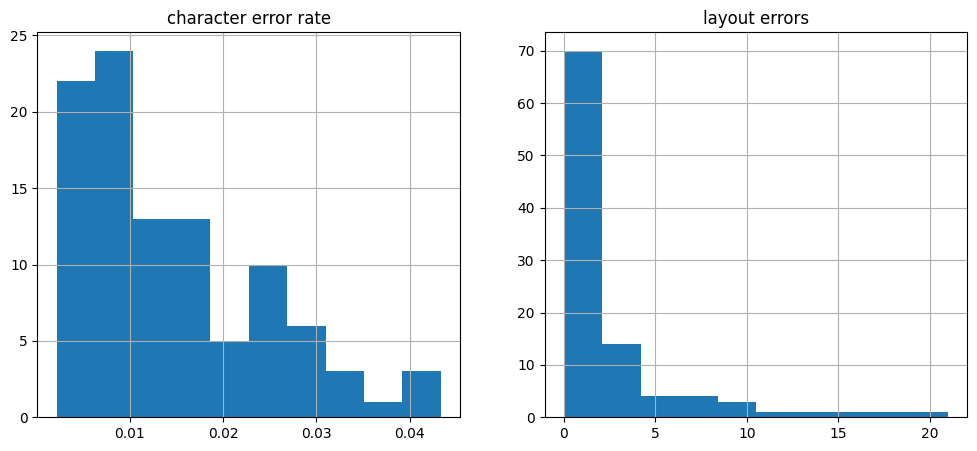

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title("character error rate")
df.allerr.hist(bins=10)
plt.subplot(122)
plt.title("layout errors")
df.layout_err.hist(bins=10);

# OCR Error Evaluation using Bounding Boxes

The above error computation operates purely on the text in the ground truth and by the OCR system.

We can also evaluate OCR systems by taking into account bounding box information. This looks for corresponding bounding boxes in the ground truth and OCR results and then compare the text associated with those bounding boxes.

This really only works well with `ocrx_word` elements, however, the dataset we're using here only contains `ocr_line`, so that's what we are using for the evaluation here. But that's also why these error rates don't correspond particularly well to the text based evaluation.

Evaluation with bounding boxes returns three metrics:

- the error rate of ground truth boxes matched by OCR output
- the number of ground truth boxes not matched by any OCR box
- the number of OCR output boxes not matched by ground truth

In [12]:
!rm -f bb_eval.db
!ocrtexteval bboxeval ocr-eval-hocr-reframed-ocr.tar --element ocr_line

0 ./A00G 7 873 2 0
84 ./W188 49 5205 0 1


In [13]:
db = sqlite3.connect('bb_eval.db')
df2 = pd.read_sql_query("SELECT * FROM bb_eval", db)
df2["err"] = df2.errors / df2.total
df2["layout_errs"] = df2.missing_ocr + df2.extra_ocr

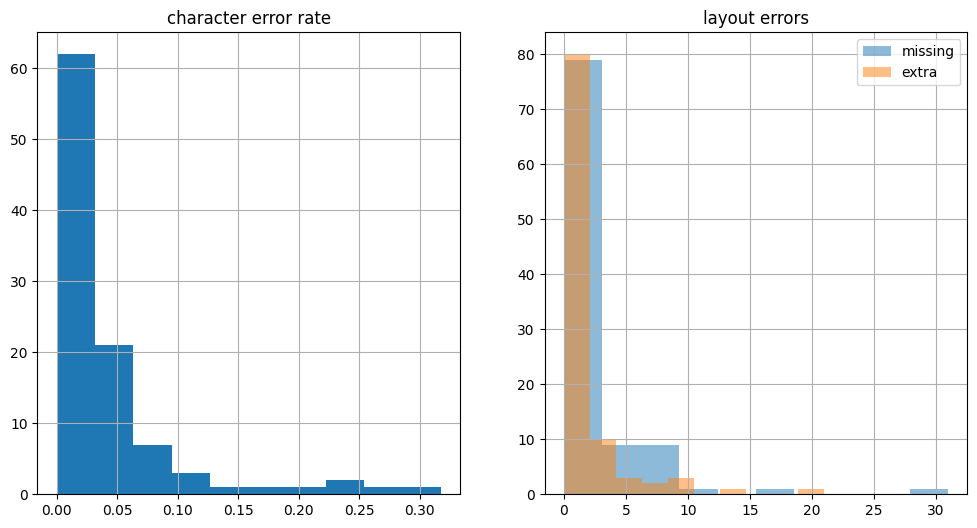

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("character error rate")
(df2.errors/df2.total).hist(bins=10)
plt.subplot(122)
plt.title("layout errors")
df2.missing_ocr.hist(bins=10, alpha=0.5, label="missing");
df2.extra_ocr.hist(bins=10, alpha=0.5, label="extra");
plt.legend();

We can look at the correlation between the text based estimate and the bounding box based estimate. Because we used `ocr_line` as the element, small errors in bounding boxes turn into large increases in error rates. On the other hand, the text based error rate estimates are somewhat more lenient than those based on bounding boxes.

For actual production use, either use the text-based error rate estimate, or the bounding box estimate with `ocrx_word` elements.

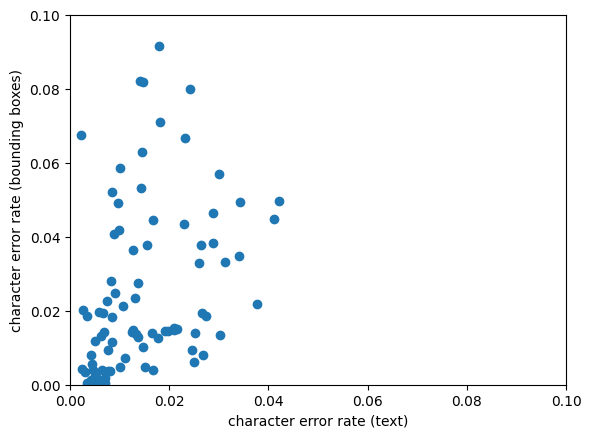

In [15]:
plt.scatter(df.allerr, df2.err)
plt.xlim(0, 0.1)
plt.ylim(0, 0.1)
plt.xlabel("character error rate (text)")
plt.ylabel("character error rate (bounding boxes)");